## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

# Loading Data and Utilities

In [1]:
import glob

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
import mpld3

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def LoadTroikaRefFile(ref_fl):
    """
    Loads the BPM array from a reference (label) file
    
    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        lbls = LoadTroikaRefFile(ref_fls[0])
        
    Args:
        ref_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy array of BPM labels.
    """
    ref = sp.io.loadmat(ref_fl)
    return ref['BPM0']

def LoadSample(idx, sigs, refs, fs=125, train=True):
    """
    Loads and bandpasses a sample returning a dict of processed data
    
    Usage:
        data_dict = LoadSample(8)
        
    Args:
        idx: The numeric index of the sample.
        sigs: List of Troika HR signal filenames
        refs: List of Troika HR label filenames
             
    Return:
        A dict containing various data points. All points in the dict have had
        a bandpass filter applied. `ppgspec` and `accspec` are spectrograms for
        the PPG signal and the acceleromter magnitude signal, respectively.
    """
    ppg, accx, accy, accz = LoadTroikaDataFile(sigs[idx])
    ts = np.arange(len(ppg)) / fs
    
    if train:
        lbl = LoadTroikaRefFile(refs[idx])
        lblhz = (lbl / 60.0)

    bppg, baccx, baccy, baccz = bandpass(ppg), bandpass(accx), bandpass(accy), bandpass(accz)

    accmag = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))
    baccmag = bandpass(accmag)
    
    freqs, _, ppgspec = sp.signal.spectrogram(bppg, fs=fs, nperseg=fs*8, noverlap=fs*6)
    _, _, accspec = sp.signal.spectrogram(baccmag, fs=fs, nperseg=fs*8, noverlap=fs*6)
    
    sample = {}
    sample['index'] = idx
    sample['ftlen'] = len(ppgspec.T)
    sample['ppg'] = bppg
    sample['accx'] = baccx
    sample['accy'] = baccy
    sample['accz'] = baccz
    sample['accmag'] = baccmag
    sample['freqs'] = freqs
    sample['ppgspec'] = ppgspec
    sample['accspec'] = accspec
    
    if train:
        sample['labels'] = lbl
        sample['labelhz'] = lblhz
    
    return sample

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    
    for idx in range(len(data_fls)):
        data = LoadSample(idx, data_fls, ref_fls)
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
        
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def RunPulseRateAlgorithm(data):
    """
    Runs the algorithm on a single sample and returns per-sample errors and confidence
    
    Args:
        data: A data dict for the sample as returned by LoadSample()
        
    Returns:
        A 2-tuple of (errors, confidence) for each 2s slice of the HR signal
    """
    # Compute pulse rate estimates and estimation confidence.
    predshz = predict_series(data)
    errors = np.abs((predshz * 60.0) - data['labels'])
    confidence = confidence_series(data, predshz)

    # Return per-estimate absolute error and confidence as a 2-tuple of numpy arrays.
    return errors.reshape(-1,), confidence.reshape(-1,)

## Algorithm Code

In [2]:
def bandpass(sig):
    """
    Applies a bandpass signal relevant to heart rate data to the input signal.
    Wrapper function for scipy.signal.butter and scipy.signal.filtfilt
    applied in that order.
    
    Usage:
        filtered_signal = bandpass(input_signal)
        
    Args:
        sig: Input signal, any value that scipy.signal.butter can take
        
    Returns:
        The bandpassed and filtered signal
    """
    lohz, hihz = 40/60.0, 240/60.0
    b, a = sp.signal.butter(3, [lohz, hihz], btype='bandpass', fs=125)
    return sp.signal.filtfilt(b, a, sig)

def hr_peaks(sig, hthresh=0.05, dist=2):
    """
    Wrapper function that finds peaks using scipy.signal.peaks 
    with values relevant to heart rate data.
    
    Usage:
        peak_indices = hr_peaks(sig)
        
    Args:
        sig: np.array containing the input signal
        
    Returns:
        Array of indices locating peaks in the signal
    """
    maxf = np.max(sig)
    minh = maxf * hthresh
    peaks, _  = sp.signal.find_peaks(sig, height=minh, distance=dist)
    
    return peaks


def predict(data,
            idx,
            pred_type='compensated',
            epsilon=0.10, 
            harmonics=lambda x: [x/2, x, x*2],
            peakthresh=0.05,
            peakdist=2):
    """
    Predicts the HR value for a single data point.
    
    Args:
        - data: The data dict as returned by LoadSample
        - idx: The index for the slice of interest within the data spectrograms
        - pred_type: 'naive' to predict the highest magnitude signal,
        'compensated' to adjust via the accelerometer data.
        - epsilon: How close an observation must be to an accelerometer peak
        for us to rule it out as a motion artifact and not a true signal.
        - harmonics: A lambda that returns an array of harmonics that we use to
        define accelerometer peaks. `x` will be the fundamental frequency of
        the accelerometer magnitude.
        - peakthresh: How tall a peak needs to be to be considered a peak, a value
        between 0.0 and 1.0 where 1.0 is the highest peak. EG: 0.5 means the peak
        must be at least half the height of the highest peak.
        - peakdist: How many samples before we can find another peak. Note that the
        Fourier transform leaves few samples so values above 3 will exclude a large
        range of the signal
        
    Returns:
        A predicted value expressed as Hz
    """
    
    ppgsig = data['ppgspec'].T[idx]
    accsig = data['accspec'].T[idx]
    freqs = data['freqs']
    
    if pred_type == 'naive':
        return freqs[np.argmax(ppgsig)]
    else:
        ppgpeakidx = hr_peaks(ppgsig, hthresh=peakthresh, dist=peakdist)
        accpeakidx = hr_peaks(accsig, hthresh=peakthresh, dist=peakdist)

        ppgpeakhz = freqs[ppgpeakidx]
        accpeakhz = freqs[accpeakidx]

        if len(ppgpeakhz) == 0:
            return freqs[np.argmax(ppgsig)]
        elif len(ppgpeakhz) == 1:
            return ppgpeakhz[0]
        else:
            candidates = ppgpeakhz
            maxacchz = accpeakhz[np.argmax(accsig[accpeakidx])]
            excludehz = np.array(harmonics(maxacchz))
            mask = (candidates == candidates)

            for fq in excludehz:
                m = np.abs(candidates - fq) > epsilon
                mask = mask & m

            filtered = candidates[mask]
            if len(filtered) == 0:
                return freqs[np.argmax(ppgsig)]
            if len(filtered) == 1:
                return filtered[0]
            else:
                peakmags = ppgsig[ppgpeakidx[mask]]
                return filtered[np.argmax(peakmags)]
            
    return None
        
        
def predict_series(data,
                   pred_type='compensated',
                   epsilon=0.10,
                   harmonics=lambda x: [x/2, x, x*2],
                   peakthresh=0.05,
                   peakdist=2):
    """
    Runs predictions on every slice of the spectrogram contained in a data dict
    
    Args:
        Refer to predict(), all args are passed through to it
        
    Returns:
        numpy array of  predictions. Shape (n,1) where n is the length of the spectrogram
    """
    
    return np.array([predict(data,
                    i,
                    pred_type=pred_type,
                    epsilon=epsilon,
                    harmonics=harmonics,
                    peakthresh=peakthresh,
                    peakdist=peakdist)
            for i in range(data['ftlen'])]).reshape(-1,1)


def confidence_series(data, preds):
    """
    Returns the confidence level in each prediction
    
    Args:
        - data: The data dict as returned by LoadSample()
        - preds: An array of predictions, as returned by predict_series()
        
    Returns:
        - An array of per-sample confidence levels of the shape (n,1) where
        n is the number of predictions/labels, matches length of the spectrogram
    """
    ppgspec = data['ppgspec']
    freqs = data['freqs']
    
    confidences = []
    for i in range(len(preds)):
        ppgsig = ppgspec.T[i]
        pred = preds[i]
        predidx = np.argmin(np.abs(pred - freqs))
        if predidx == 0:
            checkfreqs = [predidx, predidx+1]
        elif predidx == len(preds)-1:
            checkfreqs = [predidx-1, predidx]
        else:
            checkfreqs = [predidx-1, predidx, predidx+1]
        
        checkintensity = np.sum(ppgsig[checkfreqs])
        totalintensity = np.sum(ppgsig)
        confidences.append(checkintensity / totalintensity)
        
    return np.array(confidences).reshape(-1,1)


def mae(labels, preds):
    """Returns the mean average error between the labels and predictions"""
    return np.mean(np.abs(preds - labels))

## Plotting Code

In [3]:
def example_indices(data, pred_type='compensated', epsilon=10):
    """
    Returns a dict of interesting indices to be used when plotting
    
    Args:
        - data: Data dict as returned by LoadSample()
        - pred_type: 'naive' for max magnitude, 'compensated' to adjust for motion
        - epsilon: The threshold between 'good' and 'bad' predictions, in beats per minute
        
    Returns:
        A dictionary of indices: best/worst, good/bad
    """
    labels = data['labels']
    preds = (predict_series(data, pred_type=pred_type) * 60.0)
        
    indices = {}
    indices['best'] = np.argmin(np.abs(preds - labels))
    indices['worst'] = np.argmax(np.abs(preds - labels))
    indices['goodmask'] = np.abs(preds - labels) <= epsilon
    indices['badmask'] = np.abs(preds-labels) > epsilon
    indices['good'] = [i for i, v in enumerate(indices['goodmask']) if any(v)]
    indices['bad'] = [i for i, v in enumerate(indices['badmask']) if any(v)]
    
    return indices


def plot_specgram(data, key='ppg'):
    """Plotting function for spectrograms using HR algorithm windowing""" 
    mpld3.disable_notebook()
    plt.figure(figsize=(16,8))
    plt.specgram(data[key], NFFT=fs * 8, Fs=fs, noverlap=fs * 6)
    plt.ylim((0,6))


def plot_preds(data, pred_type='compensated'):
    """Plots predictions and labels based solely on maximum key frequency (naive approach)"""
    labels = data['labels']
    
    preds = (predict_series(data, pred_type=pred_type) * 60.0)
    
    mae = np.mean(np.abs(preds - labels))
    plt.clf()
    plt.figure(figsize=(14,4))
    plt.plot(labels)
    plt.plot(preds)
    plt.title("Sample %d, %s approach -- MAE: %0.3f" % (data['index'], pred_type, mae))
    plt.show()
    

def plot_slice(data, idx, pred_type='compensated'):
    """
    Plots a range of information about a single slice.
    Includes both the PPG and Accelerometer magnitude Fourier transforms,
    all the locations found by the peak finder, the predicted and actual values.
    """
    ppgspec = data['ppgspec']
    accspec = data['accspec']
    freqs = data['freqs']
    lblhz = data['labelhz']
    
    ppgsig = ppgspec.T[idx]
    accsig = accspec.T[idx]
    frame = freqs < 4.0
    
    plt.clf()
    plt.figure(figsize=(14,4))
    
    # Plot PPG frequencies
    plt.plot(freqs[frame], ppgsig[frame]) 
    
    # Plot PPG Peaks
    ppgpeaks = hr_peaks(ppgsig)
    ppgpeakfreqs = freqs[ppgpeaks]
    ppgpeakheights = ppgsig[ppgpeaks]
    
    plt.scatter(ppgpeakfreqs, ppgpeakheights, marker='*', s=1000, c='Green')
    
    # Plot Label
    label = lblhz[idx][0]
    labelidx = np.argmin(np.abs(freqs-label))
    labelheight = ppgsig[labelidx]
    
    plt.scatter(freqs[labelidx], labelheight, marker='*', s=400, c='Red')
    
    # Plot Prediction
    pred = predict(data, idx, pred_type=pred_type)
    predidx = np.argmin(np.abs(freqs - pred))
        
    plt.scatter(freqs[predidx], ppgsig[predidx], marker='*', s=400, c='Yellow')
    
    # Plot Summary Info (must be done before calling twinx())
    plt.title(f'Slice {idx} -- Approach {pred_type}')
    plt.xlabel(f'Peaks (Green *) -- Predicted BPM: {np.round(pred * 60.0, 2)} (Yellow *) -- Actual BPM: {np.round(label * 60.0, 2)} (Red *) -- Actual Hz: {np.round(label, 2)}')
    
    # Plot ACC Frequencies
    plt.twinx()
    plt.plot(freqs[frame], accsig[frame], color='Goldenrod')
    
    # Plot ACC Peaks
    accpeaks = hr_peaks(accsig)
    accpeakfreqs = freqs[accpeaks]
    accpeakheights = accsig[accpeaks]
    
    plt.scatter(accpeakfreqs, accpeakheights, marker='2', s=1000, c='Green')
    
    print(f"PPG Peaks: {ppgpeakfreqs}")
    print(f"ACC Peaks: {accpeakfreqs}")

# EDA

## Load and Bandpass

### Good Reference Points:

- 0: Examples of signals with no HR signal.
- 11: Examples of signals where jumping to another peak often fixes the problem. Also high MAE on the base algorithm.

In [4]:
# Load a reference point
fs = 125
sigs, refs = LoadTroikaDataset()
data = LoadSample(8, sigs, refs)

In [5]:
len(sigs)

12

## Spectrograms

### PPG

In [6]:
%matplotlib inline

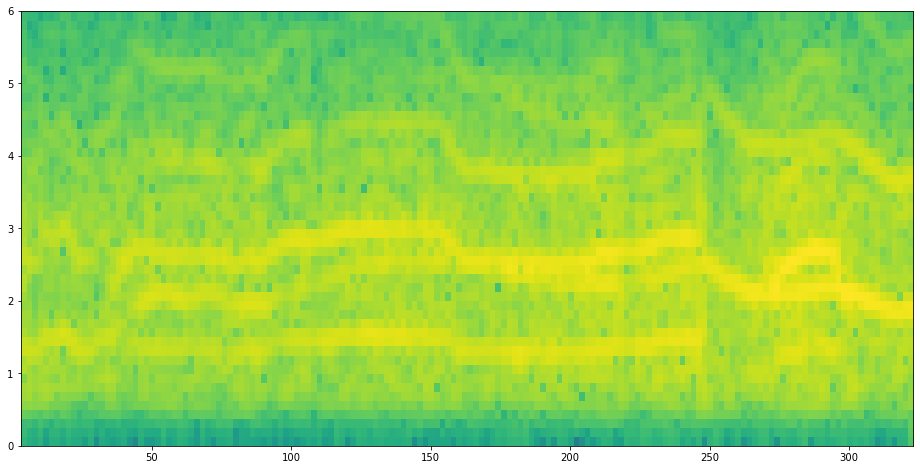

In [7]:
plot_specgram(data, key='ppg')

### Accelerometer

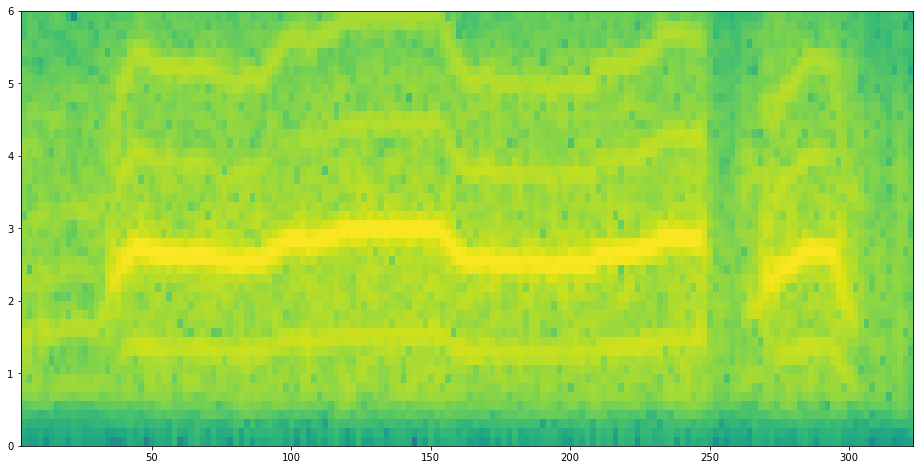

In [8]:
plot_specgram(data, key='accmag')

Using settings borrowed from the white paper on TROIKA we're trying an 8s window size that slides by 2s every time. This is also good because the output length matches to our labels. From that we can make basic predictions using just the dominant frequency times 60.

## Evaluating the Naive Approach

We'll be comparing everything here to a simple approach where we always choose the strongest PPG signal as the heart rate frequency and multiply that by 60 to get our prediction.

In [9]:
predict(data, 23)

2.0

<Figure size 432x288 with 0 Axes>

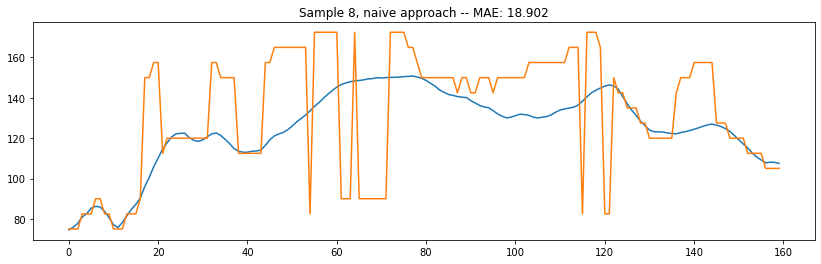

In [10]:
plot_preds(data, pred_type='naive')

A very mixed bag here where the algorithm is very accurate in some cases and way off in others. The MAE is too high, we'll need to incorporate more techniques to get this down. Let's look at some example slices.

_Note: Commentary is vague here because different samples have different issues._

In [11]:
naive_examples = example_indices(data, pred_type='naive')

### Worst Slice

PPG Peaks: [1.    1.375 2.125 2.5   2.75  3.125]
ACC Peaks: [2.75]


<Figure size 432x288 with 0 Axes>

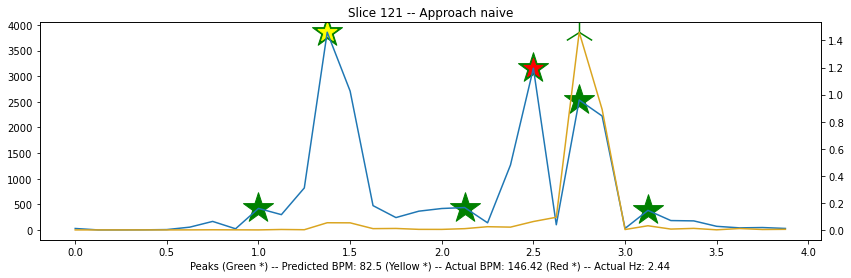

In [12]:
plot_slice(data, naive_examples['worst'], pred_type='naive')

### Best Slice

PPG Peaks: [0.75  1.    1.375 2.875]
ACC Peaks: [1.5   2.25  3.125]


<Figure size 432x288 with 0 Axes>

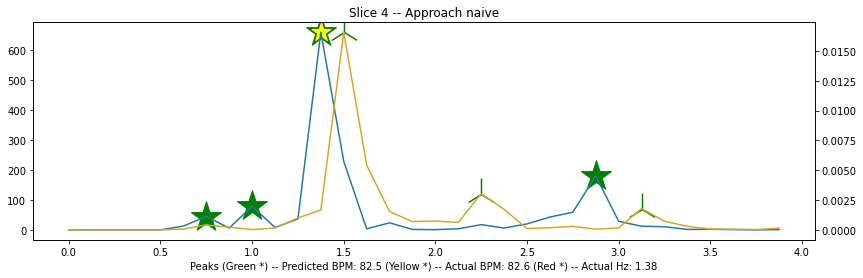

In [13]:
plot_slice(data, naive_examples['best'], pred_type='naive')

### Assorted Good Slices (<10bpm difference)

This can be run over and over to get a new good slice, make sure to note indices of interest.

PPG Peaks: [1.75  3.625]
ACC Peaks: [0.625 1.    1.375 1.75  2.25  2.5   2.875 3.25  3.75  4.25 ]


<Figure size 432x288 with 0 Axes>

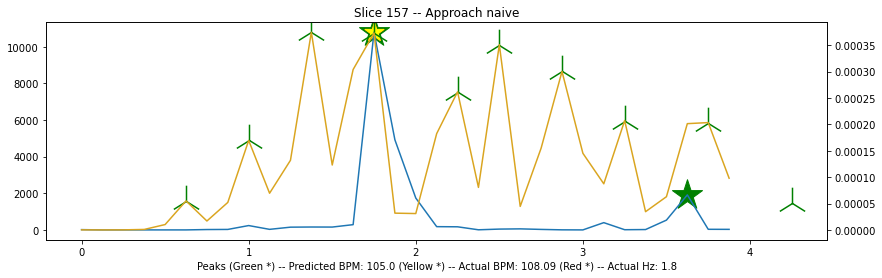

In [14]:
plot_slice(data, np.random.choice(naive_examples['good']), pred_type='naive')

### Assorted Bad Slices (>10bpm difference)
This can be run over and over to get a new bad slice, make sure to note indices of interest.

PPG Peaks: [1.25  2.125 2.5   3.625]
ACC Peaks: [2.5]


<Figure size 432x288 with 0 Axes>

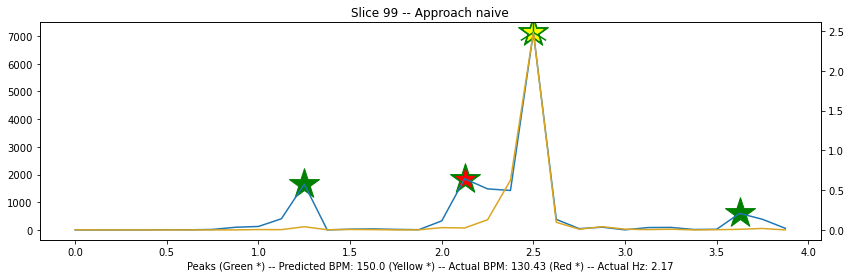

In [15]:
plot_slice(data, np.random.choice(naive_examples['bad']), pred_type='naive')

## EDA Conclusions

Looking at a number of observations a few things are clear:

1. Often the true HR value appears at a peak that is not the one we picked. Determining algorithmically when we should choose this other peak is difficult.
2. In some cases the true value is in an area with no peak at all and reasonably we cannot ever pick these with confidence.

There are, however, two cases that we can probably deal with:

1. The dominant frequency of the PPG coincides with the dominant frequency on the accelerometer, or one of its harmonics. In that case we can look for a signal that is not reflected in the accelerometer and choose that. Note that in some cases the true signal and the accelerometer signal do overlap and with these we'll have no solid basis for making/changing our decision. When looking for harmonics/overlapping frequencies a value of 0.2Hz seems to work well.
2. In some cases the dominant frequency does _not_ appear as a fundamental/harmonic frequency on the accelerometer but it is still wrong (See idx=11 slice=3). In this case the dominant frequency is actually a _harmonic_ of the HR. There is hope for identifying these. In many cases we see large errors when the HR jumps 20+ bpm in magnitude between observations, an impossible leap over such a short time. In that case we can look for another peak with a frequency closer to our previous observation(s). 

## Algorithm Outline

Based on the EDA we can take the following approach:

**Predicting**
1. When there is only one peak found for the PPG signal there is nothing more we can do, we don't have enough information to accept any other conclusion.
2. When there are multiple peaks we consider all of them as "candidates", next we look at the dominant frequency in the accelerometer data as well as harmonic frequencies at 1/2x and 2x the dominant frequencies.
3. Any candidates that line up with these frequencies (within a range of 0.2Hz) are removed from consideration.
4. If we have candidates left after this we choose the one with the highest magnitude. If we _don't_ have candidates left we go back to accepting our original estimate of the highest magnitude.
5. We generate a confidence number based on the total ratio of the power in our chosen frequency. 

**Smoothing**
1. If we have a low-confidence estimate that _also_ sees a major change in HR we can try to smooth that observation out by filling it in with a previous, high-confidence estimate based on the logic that HR doesn't change quickly. 

# Motion-Compensated Predictions

_Note: The code for all this has been moved up to the WALLOFCODE at the top but it follows the general outline explained directly above._

In [16]:
compensated_examples = example_indices(data, pred_type='compensated')

<Figure size 432x288 with 0 Axes>

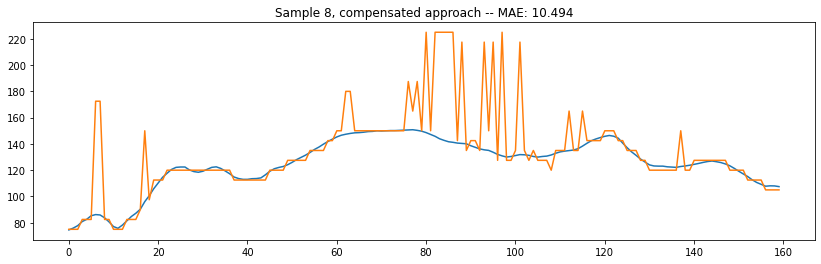

In [17]:
plot_preds(data)

### Worst Slice

PPG Peaks: [1.25 2.5  3.75]
ACC Peaks: [2.125 2.5  ]


<Figure size 432x288 with 0 Axes>

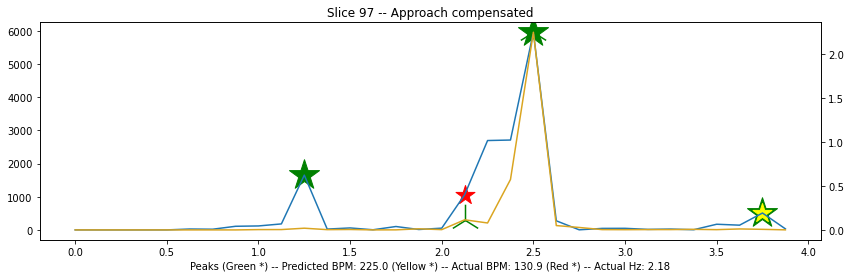

In [18]:
plot_slice(data, compensated_examples['worst'])

### Best Slice

PPG Peaks: [1.5   2.5   2.875]
ACC Peaks: [2.875]


<Figure size 432x288 with 0 Axes>

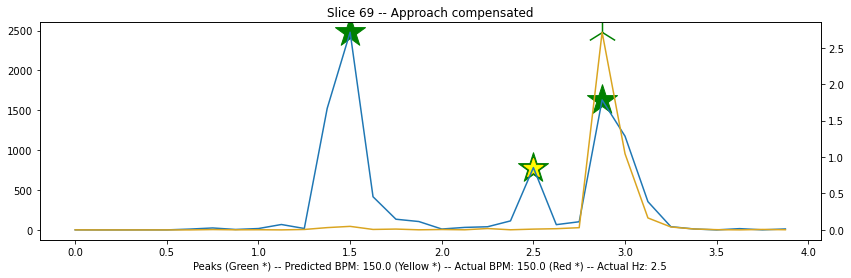

In [19]:
plot_slice(data, compensated_examples['best'])

### Most Confident Slice

PPG Peaks: [2.25]
ACC Peaks: [0.75  1.    1.375 1.875 2.125 2.625 2.875 3.375]


<Figure size 432x288 with 0 Axes>

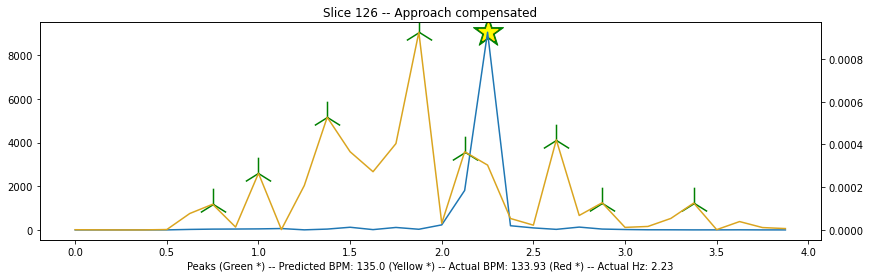

In [20]:
confs = confidence_series(data, predict_series(data))
plot_slice(data, np.argmax(confs))

### Least Confident Slice

PPG Peaks: [1.25 2.5  3.75]
ACC Peaks: [2.5]


<Figure size 432x288 with 0 Axes>

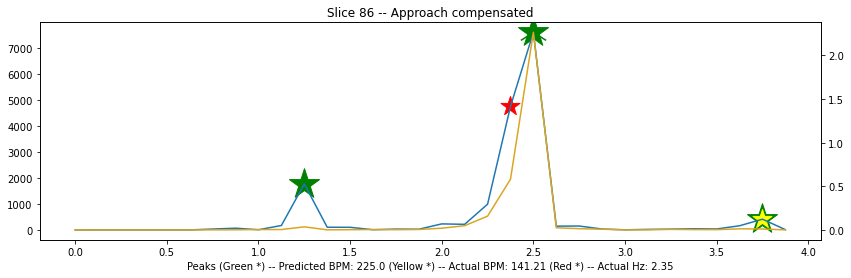

In [21]:
plot_slice(data, np.argmin(confs))

### Assorted Good Slices (<10bpm off)

PPG Peaks: [1.375 2.375 2.875]
ACC Peaks: [2.875]


<Figure size 432x288 with 0 Axes>

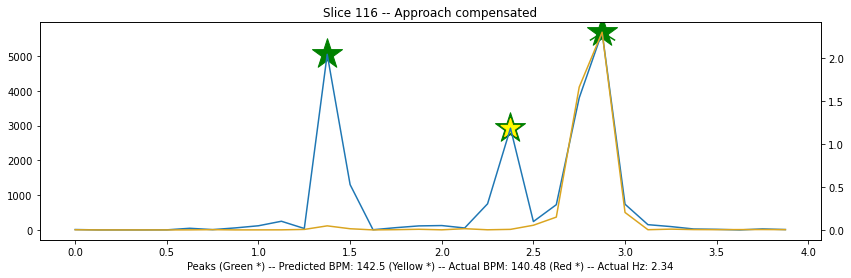

In [22]:
plot_slice(data, np.random.choice(compensated_examples['good']))

### Assorted Bad Slices (>10bpm off)

PPG Peaks: [0.875 1.375 2.25  2.75  3.25 ]
ACC Peaks: [2.875]


<Figure size 432x288 with 0 Axes>

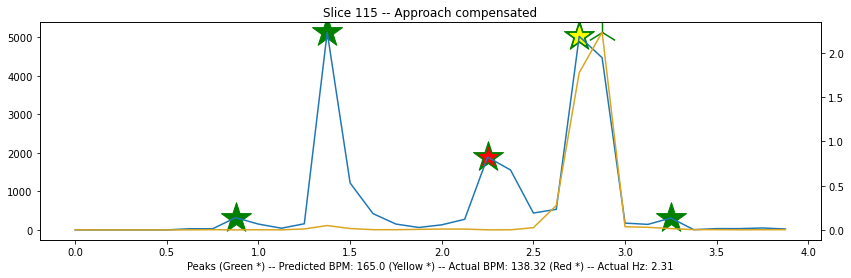

In [23]:
plot_slice(data, np.random.choice(compensated_examples['bad']))

## Hyperparameter Tuning

In [24]:
errors = []
for i in range(len(sigs)):
    dat = LoadSample(i, sigs, refs)
    labels = dat['labels']
    preds = (predict_series(dat,
                           pred_type='compensated',
                           epsilon=0.10,
                           harmonics=lambda x: [x/2, x, x*2],
                           peakthresh=0.05,
                           peakdist=2) * 60.0)
    
    errors.append(mae(labels, preds))
    
for i, v in enumerate(errors):
    print("%d: %0.3f" % (i, v))
    
print("\nAverage MAE: %0.3f" % np.mean(errors))

0: 21.999
1: 9.897
2: 9.207
3: 13.405
4: 8.138
5: 4.690
6: 14.258
7: 11.283
8: 10.494
9: 21.952
10: 12.894
11: 16.989

Average MAE: 12.934


In [25]:
np.max(errors)

21.9989077859818

In [26]:
np.min(errors)

4.690265753424658

In [27]:
np.std(errors)

5.03871961020146

# Evaluation

In [28]:
Evaluate()

11.303819465256188

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

# Write Up

## Data Description

The data includes a two-channel PPG signal to provide heart rate data, a three-axis accelerometer signal that can help identify motion artifacts, and an ECG signal that provides the baseline/labels for this set. The participants in the study performed alternating running and jogging at a rate of either $6 \rightarrow 12 \rightarrow 6 \rightarrow 12$ kph with each segment lasting one minute, or the same thing with the speeds being $8 \rightarrow 15 \rightarrow 8 \rightarrow 15$ kph. After each of these there is a 30s rest segment. 

No knowledge of the specifics of the dataset was used in the construction of the algorithm but we could theoretically leverage a few things here: 1) Each participant starts from a less-active state and so the HR should fall in a more predictable zone. 2) We expect motion artifacts to intensify when the participant goes from resting to jogging or jogging to running. This could be useful for finding regions of more/less motion artifacts. 

The dataset includes only 12 training examples, and of those the variance in terms of algorithm performance (a proxy measurement for the complexity of the example) varies a lot. Ideally we would want more training data. Outside of that the dataset is well constructed with a good ground truth measurement coming from the ECG sensor and each example giving a varying level of motion artifacts per participant. Since we are evaluating a primarily manual and rules-based approach the data is more for the evaluation of the algorithm than it is for training it so the small size of the dataset harms us less here than it would with other approaches. 


## Code Overview

### General

The entry point for essentially everything is `LoadSample` which returns a data dict containing all the raw and processed data as well as labels. `LoadSample` performs preprocessing operations like bandpass-ing and generating spectrograms. This can be passed to most of the processing methods. All of the functions themselves are well documented but a few specific ones to point out here:

### Predicting

- `predict(data, idx)` is the main method here. `idx` is the index within the spectrogram. It has a number of hyperparameters that can be tuned and can even return a "naive" prediction which is simply returning the highest magnitude PPG signal while ignoring all the motion data. It returns a frequency in Hz.
- `predict_series(data)` is a convenience function that applies the above method to the entire spectrogram and takes the same hyperparameter arguments.
- `confidence_series(data, preds)` generates a set of confidence metrics given a set of predictions.
- `hr_peaks` is a peak finder function with defaults optimized for heart rate data but these can be overwritten.
- `bandpass` performs the signal filtering operation for the frequencies of interest to us.


### Plotting

- `example_indices` is a useful method that will arrange all the spectrogram slices into groups of 'good'/'bad', where the line between the two is defined by epsilon, it also marks the best and worst slices. Passing these to `plot_slice` is good for gaining intuition about examples the algorithm is performing well/poorly on. 
- `plot_preds` performs predictions on its own so can be run by just passing in a data dict. 
- `plot_specgram` needs a key from the data dict, most common will be `bppg` (bandpassed ppg) and `baccmag` (bandpassed accelerometer magnitude. This is a slightly _different_ spectrogram than the one used for predictions as they come from different libraries but it's sufficient to visualize.
- `plot_slice` is long but ultimately it's just comparing the two raw signals for a slice of the spectrogram, marking the peaks, then plotting the predicted and true labels. 


## Code Examples/Guide

### Loading a sample and predicting a single slice

```python
# Load a training example
sigs, refs = LoadTroikaDataset()
instanceidx = 8
data = LoadSample(instanceidx, sigs, refs)

# Select a slice and generate a prediction (using default hyperparameter values)
sliceidx = 37
predhz = predict(data, sliceidx)
predhr = predhz * 60.0
```

### Predicting a full training instance and getting error

```python
# Load a training example
sigs, refs = LoadTroikaDataset()
instanceidx = 8
data = LoadSample(instanceidx, sigs, refs)

# Make predictions on every slice
predshz = predict_series(data)

# Convert to HR values
predshr = (predshz * 60.0)

# Get labels
labels = data['labels']

# Generate mean-average error
maerror = mae(labels, predshr)
```

### Predicting a full instance and changing a hyperparameter

```python
# Load a training example
sigs, refs = LoadTroikaDataset()
instanceidx = 8
data = LoadSample(instanceidx, sigs, refs)

# Make predictions on every slice
# Here we remove the checks at harmonic values x*2 and x/2
# we also increase the minimum peak height to 10% of max
predshz = predict_series(data, harmonics: lambda x: [x], peakthresh=0.10)

# Convert to HR values
predshr = (predshz * 60.0)

# Get labels
labels = data['labels']

# Generate mean-average error
maerror = mae(labels, predshr)
```


## Algorithm Overview

The naive approach to this problem is threefold: 1) Preprocess the signals with a bandpass filter, generate a spectrogram using appropriate window size and slide amount, and finally 3) predict the highest magnitude signal from the Fourier transform of each slice of the spectrogram (multiplied by 60 gives us a heart rate).

As the PPG signal is subject to a lot of motion artifacts we need to try and control for these using data from the accelerometer sensors. To do this we first take the total magnitude of the accelerometer readings. This involves squaring each axis, adding them, then taking the square root of the sum. Then this is converted into an equivalent spectrogram.

From here we follow the intuition that the heart rate signal should still manifest as a peak in the PPG Fourier transform, but we can no longer choose simply the highest point. First we need to find peaks for both the PPG and accelerometer spectrograms. Then we follow the assumption that a PPG signal is a motion artifact if it exists at the same frequency as the strongest frequency in the accelerometer spectrogram, or at one of its harmonics. We define harmonics here as `x/2` and `x*2` where `x` is the strongest frequency of the accelerometer. The PPG peaks that fit this criteria are discarded and we choose the strongest PPG peak that remains. If all peaks are eliminated via this approach we revert to choosing the highest peak on the PPG Fourier transform.

This approach performs better than the naive approach. That said there are so many unique cases with this kind of processing that it still struggles on specific cases. The two most significant issues are: 1) It naturally fails to find the correct frequency when the heart rate and the accelerometer frequencies overlap, and 2) It doesn't incorporate any intuition that heart rate is a slowly changing quantity and so will often predict jumps of 20+ bpm over a two second window. There is a final case where the correct frequency does not occur at or near a peak at all, but it's unlikely that any algorithm could properly identify this. 


## Algorithm Performance

The algorithm generates a mean-average error (MAE) across all samples of 12.93bpm. The max error is 22bpm, the min error is 4.69bpm and the standard deviation is 5.04bpm. Excluding the 10% of predictions with the lowest confidence drops total MAE to 11.30bpm, indicating that the confidence metric is useful in discriminating between good/bad estimates. The choice of MAE over something like mean-squared error (MSE) is that MSE penalizes extreme outliers exponentially, but in this dataset errors are often extreme when they are made and this is an unavoidable side-effect of the approach taken. As a result we want to avoid measuring just the extreme errors (which MSE tends towards) and instead look at an overall metric (MAE). 

The algorithm was optimized by tuning hyperparameters on the entire training set. Using the entire set rather than splitting into train/test is justified for two reasons. First, there is high variance between samples in terms of the error rate. The worst example has an error of 22bpm while the best example is <5bpm off. Since we only have 12 observations the random split could easily create samples that were not representative or informative.

Second, the algorithm already has a high bias. The approach is really just a straightforward heuristic approach and the only variable/learned quantities are the hyperparameters defining the values of the harmonics and the behavior of the peak finder. If these were set to extreme/illogical values that would probably represent overfitting but most of them were ultimately best when set to have minimal overall effect. 

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 